# A general procedure for supervised learning

**Note: This is part 2 of CL1, you should complete part 1: "cl1_linear_regression.ipynb" before continuing with this one.**

In this second part we create a classification model in two ways.
First, we'll do it with basic python, to help you understand the inner details of `pytorch`.
Then we'll re-do it in the standard way, the way you are supposed to use `pytorch`.
The goal is to make you comfortable with using `pytorch` and also to show how such machine learning problems are generally solved.

For most supervised learning tasks, the procedure we follow is comprised of the following steps:

### Step 1: Data exploration
The first step is normally to load the data and try to understand its properties. A few things that are usually useful:
1. Check data formats.
2. Visual inspection of data.
3. Investigate (get some type of understanding for) how hard the problem is. 


### Step 2: Data preprocessing
1. Normalise (or scale) input data. 
2. Convert the data to a different type, or organize it differently for the optimization (e.g. Numpy arrays, subsets of the dataset, etc.)
3. Encode input and output data on a suitable form. For instance, we often use one-hot encoding to represent string variables.
4. Split data into training, validation and test sets.


### Step 3: Training
1. Build a tentative network architecture (could be the simplest one you think could work, or based in previous sucesses). Here we'll do it in two ways to show you `pytorch` behind the scenes.
2. Select optimizer, performance measures and a few more hyperparameters. 
3. Train the network. 
4. Analyze performance on the training and validation sets. Adjust design decisions accordingly.


### Step 4: Assessment
1. Use the network for predictions in the test set.
2. Evaluate the final quality of the model. **Note**: Once this is done, you shouldn't alter your model anymore, otherwise you need a new test set (if you want a good estimate of your model's generalisation capacity).

We are going to apply most of these steps to the task of correctly classifying an Iris plant, given its morphologic features present in the IRIS dataset.

# 1. Data exploration

### 1.1  Import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

### 1.2 Read the dataset

In [2]:
dataset = pd.read_csv("iris.csv")

In [3]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### 1.3 Analyzing the data

For this task, we'll use all of the data, not only focusing on one of the species or a subset of the features. The `plot` method can help us obtain different types of visualizations of the data in the `DataFrame`. For instance, we can use it to plot histograms of each feature.

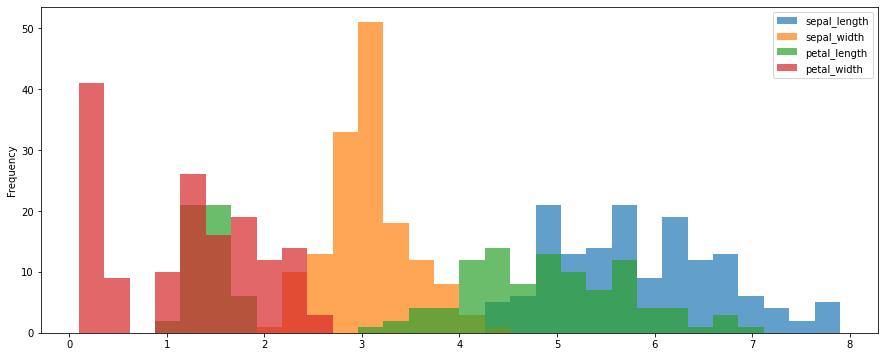

In [4]:
dataset.plot(kind='hist', bins=30, alpha=0.7, figsize=[15,6]);

This is somewhat informative, but we could get an even better grasp of the data by first separating it into the different species (it seems likely that different species will have different feature distributions), and then plotting the histograms.

However, if we let the `plot` method automatically create the histogram bins where it wants, each histogram might have different ranges, which would make it harder to compare them. Instead, we create the bins ourselves and pass that as an argument.

In [5]:
# Remove the 'species' column, so we get only the numeric values of the dataset
features_dataset = dataset.drop('species', axis=1)

# Find maximum and minimum values
maxval = np.max(features_dataset.values)
minval = np.min(features_dataset.values)

# Create 30 linearly spaced numbers in this range
my_bins = np.linspace(minval, maxval, 30)
print(my_bins)

[0.1        0.36896552 0.63793103 0.90689655 1.17586207 1.44482759
 1.7137931  1.98275862 2.25172414 2.52068966 2.78965517 3.05862069
 3.32758621 3.59655172 3.86551724 4.13448276 4.40344828 4.67241379
 4.94137931 5.21034483 5.47931034 5.74827586 6.01724138 6.2862069
 6.55517241 6.82413793 7.09310345 7.36206897 7.63103448 7.9       ]


In [6]:
# Get the names of the species
species_names = dataset['species'].unique()
print(species_names)

['setosa' 'versicolor' 'virginica']


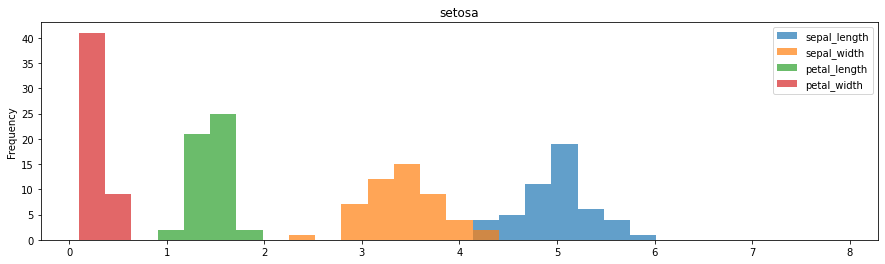

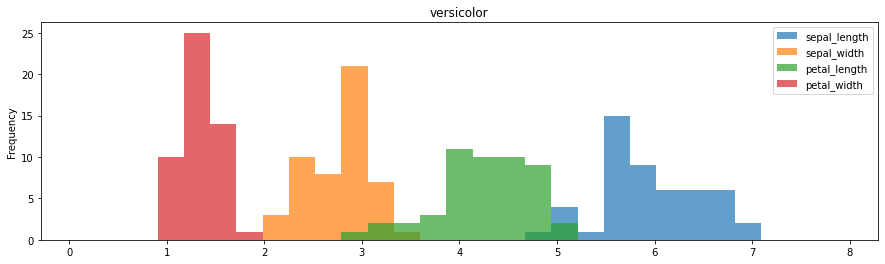

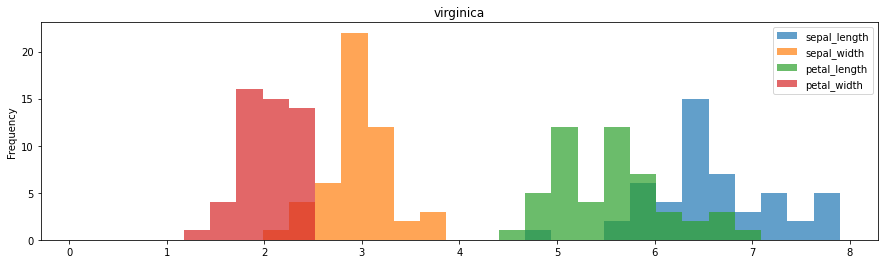

In [7]:
# For each species name, plot a histogram
for name in species_names:
    dataset[dataset["species"]==name].plot(kind="hist", bins=my_bins, alpha=0.7, figsize=[15,4], title=name);

This confirms that different species do have substantial differences in the distributions of each feature, e.g. the Setosa species has shorter sepals than the others, etc. 

Another way to gain more insight about the data is using the method `pairplot`, from the seaborn python module. This shows scatter plots between all feature pairs (hence the time required to run it increases exponentially with the number of features!) and histograms for each feature, color-coded by the species.

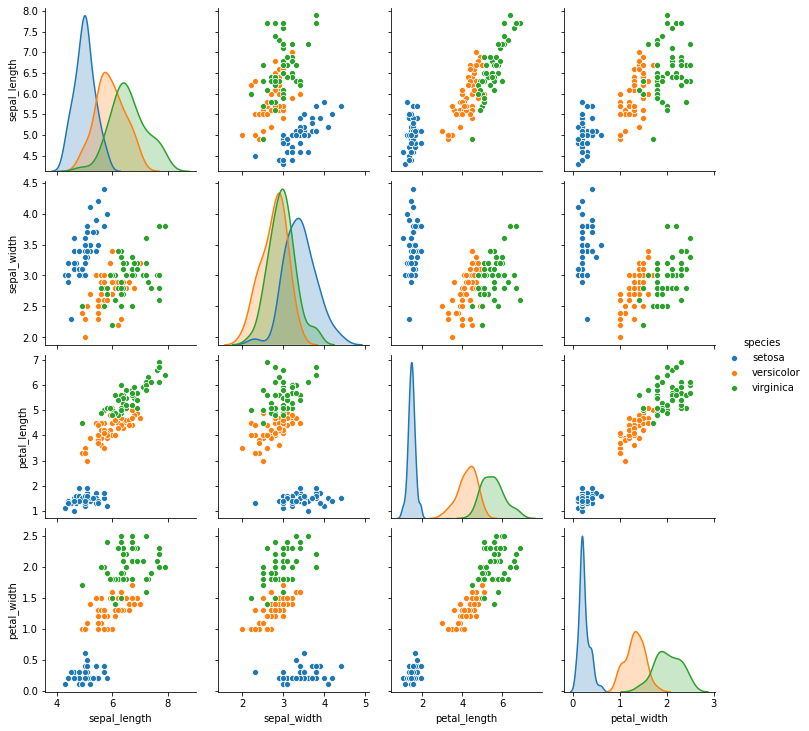

In [8]:
sns.pairplot(dataset, hue='species');

It's also helpful to check if the dataset is balanced. We can do so like this:

In [9]:
# Fill in a dictionary with the number of ocurrences of each species
n = {}
for name in species_names:
    extract_rule = dataset['species']==name
    n[name] = len(dataset[extract_rule])
    
print(n)

{'setosa': 50, 'versicolor': 50, 'virginica': 50}


This shows that each species occurs exactly 50 times in the dataset, so it's perfectly balanced.

# 2. Data preprocessing

### 2.1 Preparing input and output vectors

Now we need to prepare the data for the training. The first thing we should do is define the input and the output arrays for our network. 

Defining the input is as simple as extracting only the numeric columns of the dataset (this can also be conveniently done using the `drop` method, as done before).

In [10]:
# Extract numerical values
# `.values` extracts the data as an numpy array
x = dataset[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

# Print first 10 rows
print(x[:10])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


Creating the output vector requires one more step, because of the way we'll train our network. Since the optimizer needs to be able to compare the predictions made by the neural network (i.e. a numeric vector), with the desired output vector in order to decide how to alter the weights, it's usually necessary to encode the output vector in a numeric format, instead of strings:

In [11]:
dataset['species'].values[:5]

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa'], dtype=object)

First we create a handy function to map the species strings to numbers.

In [ ]:
def encode_species(species):
    if species == 'setosa':
        return 0
    if species == 'versicolor':
        return 1
    if species == 'virginica':
        return 2
    else:
        raise ValueError('Species \'{}\' is not recognized.'.format(species))

We then use `map` to apply it to every element in the dataset.

In [ ]:
temp = map(encode_species, dataset['species'].values)
y = np.array(list(temp))

In [ ]:
y[0:5]

### 2.2 Test split

Secondly, in order to assess how well our classifier generalizes to new, unseen data, we would like to withhold part of the dataset from the training process. This withheld part is usually called the test set. 

Scikit-learn conveniently provides `train_test_split` function for exactly this purpose. 

In [ ]:
from sklearn.model_selection import train_test_split

This method randomly chooses which examples will be withheld, and here we want the test set to be comprised of approximately 30% of the samples.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

In [ ]:
x_train.shape

In [ ]:
x_train[:5]

In [ ]:
y_train.shape

In [ ]:
y_train[:5]

In [ ]:
x_test.shape

In [ ]:
y_test.shape

Now we can use `x_train` and `y_train` to train the network, and `x_test` and `y_test` to evaluate it.

## 3 Training a network using basic python and autograd
Now comes the part where we start using ``pytorch`` to create a model. This time though, we are going to do it on a low level to show you what is happening behind the scenes.
We will use `pytorch` to train a neural network with a single hidden layer.

`pytorch` contains a number of modules and classes that enable us to define and train neural networks in a compact and elegant manner. However, since it is so compact it may at first be challenging to understand what's going on under the hood. In order to clarify what the different modules do, we will first present the code using basic Python commands and the `autograd` package from `pytorch`. After that we will introduce standard `pytorch` commands for expressing the code more compactly.

More details on the `autograd` package can be found [here](https://`pytorch`.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py) and [here](https://`pytorch`.org/docs/stable/notes/autograd.html). Note that `pytorch` works with tensors (type = `torch.Tensor`) but since they work very similarly to numpy arrays we do not teach them separately. 

In order for `autograd` to work, we first need to change our data from Numpy arrays to Torch tensors.

In [ ]:
import torch
# A `numpy array` can easily be made into a `torch.Tensor´
torch_x = torch.tensor(x_train, dtype=torch.float32)
torch_y = torch.tensor(y_train, dtype=torch.int64)

Note: if we don't provide the argument `dtype`, the `tensor` function tries to infer the type of the `Tensor` that will be created from the type of the data supplied. In this case, this is a problem, since `x_train` is of type `float64`:

In deep learning usually memory is a bottleneck, so it's common to use `float32` for the parameters of the neural network. Having the input (in this case `x_train`) as `float64`, and the parameters of the net as `float32` causes `pytorch` to throw an error, and is a common mistake.

We don't have the same problem with `y_train` because its type is already the correct one for the loss we will use.

### 3.1 Introducing the network parameters
We will use a simple logistic regression network with four inputs (one for each feature) and three output (one for each class). By turning on `requires grad`, `autograd` will keep track of all operations performed on these tensors and help us compute gradients.  

In [3]:
import torch
weights = torch.randn(4, 3)
weights.requires_grad_()
bias = torch.zeros(3, requires_grad=True)
bias

tensor([0., 0., 0.], requires_grad=True)

### 3.2 Defining the model and the loss function

To match the notation that we use in `pytorch`, we define the model as being just the linear layer, since the softmax function is here included in loss function (this is merely a design choice in our code). In terms of our standard notation, the "model" outputs $z$.

In [ ]:
def model(x):
    # Note how `pytorch` reuses `numpy`s @ notation" for matrix multiplication.
    return x @ weights + bias

$
\def\x{\mathbf{x}}
\def\yTrue{\mathbf{y}}
\def\z{\mathbf{z}}
\def\p{\mathbf{p}}
\def\loss{\mathcal{L}}
$
To compute the loss, we should now compute the softmax of the output of our model, 
$$
\p_j = \frac{\exp(\z_j)}{\sum_i \exp(\z_i)},
$$
which becomes the output from the logistic regression/our neural network. Note that the output vector $p$ represents the probability distribution $\text{Pr}[y | \x^{(i)}, \theta]$, for the input $\x^{(i)}$. We use the negative log likelihood,
$$
- \log \text{Pr}[y^{(i)} | \x^{(i)}, \theta]
$$
as our loss and average that across our data points, i.e., over different values of $i$. We can express these operations on a compact form using standard Python commands: 

In [ ]:
def log_softmax(z):
    """Takes output from model and applies softmax and log"""
    return z - z.exp().sum(-1).log().unsqueeze(-1)

def nll(z, target):
    """Takes output from model and computes the loss"""
    logprob = log_softmax(z)
    return -logprob[range(target.shape[0]), target].mean()

loss_fn = nll

### 3.3 Training the network
To train the network we will do the following:

* Select a minibatch of data.
* Compute the loss for this data.
* Perform a step of gradient descent.

We do this for a number of epochs. To perform gradient descent, the method `.backward()` from the `autograd` packages is used to compute the gradients with respect to all variables for which `requires_grad=True`.


In [ ]:
# Number of epochs, batch size, number of training data and learning rate
epochs    = 20 
batchsize = 32
m         = len(torch_y)
lr        = 0.1

for epoch in range(epochs):
    # We use this to compute the average loss in each epoch
    losses = []
    for i in range((m - 1) // batchsize + 1):
        #  Extracting the data in the current minibatch
        start = i * batchsize
        end   = start + batchsize
        b_x   = torch_x[start:end]
        b_y   = torch_y[start:end]
        
        # Computing the loss for the current minibatch
        pred = model(b_x)
        loss = loss_fn(pred,b_y)
        losses.append(loss.item()) # and storing to print the number below
        
        # Performing a step of gradient descent
        loss.backward()
        # `autograd` registers every change to our parameters.
        # However, the actual gradient step should not affect the gradient.
        # Python has the key word `with` which creates a scope in our code.
        # Here, we use it to temporarily disable `autograd`. After the indented block,
        # `autograd` automatically resumes.
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            # We need to end with weights.grad.zero_() and bias.grad.zero_()
            # in order to reset the gradient calculations in autograd
            # before computing the gradients for the next minibatch.
            weights.grad.zero_()
            bias.grad.zero_()
            
    # Computing and printing the average loss in the current epoch
    avg_loss = sum(losses)/len(losses)
    print('Epoch: {}\tAvg loss: {}'.format(epoch, avg_loss))

## 4 Simplifying the code with `pytorch`
There are a number of things that we can do to make the code shorter. Once you understand what the different modules do, shorter code also means that it is faster for you to read and write it, and it may also run faster. It will probably also be less prone to errors since we leverage on built-in commands to a much greater extent. We here consider three types of adjustments. 

### 4.1 Data loaders
First, we often create data loaders using `TensorDataset`and `DataLoader`.

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
t_dataset = TensorDataset(torch_x, torch_y)
t_data_loader = DataLoader(t_dataset, batch_size=32, shuffle=True)

Once these are in place, we can simply write 
```python
for b_x, b_y in t_data_loader: 
```

instead of 

```python
for i in range((m - 1) // batchsize + 1):
    #  Extracting the data in the current minibatch
    start = i * batchsize
    end   = start + batchsize
    b_x   = torch_x[start:end]
    b_y   = torch_y[start:end]
```

### 4.2 Model, loss functions and optimizer
Second, we typically define our models as a `torch.nn` class. This enables us to initiate and update all model parameters in a more unified fashion and we do not explicitly specify and update all the different weights and biases in the model.

We will use a neural network which only has one hidden layer. The input to this hidden layer are the features for each sample, which are 4-dimensional. The output of it will be 3-dimensional, consisting of one number for each of the three classes, corresponding to how likely the model thinks the input is from that class.

In [ ]:
from torch import nn

In [ ]:
# Our model inherits from `nn.Module`, just as with the `LinearRegressor` in CL1.
class LogisticRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 3)

    def forward(self, x):
        return self.lin(x)
    
model = LogisticRegressor()

In the above, `model` becomes an instantiation of the class `LogisticRegression`. Instances of these classes are callable and `model(x)` directly evaluates the method `model.forward(x)`.

We can also make use of the built-in functions in PyTorch's `nn` classes, instead of writing our own functions. For instance, the loss function that we defined above is known as the `CrossEntropyLoss`:

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Note we didn't use a softmax activation for this model. The loss we will use, `pytorch`'s [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), already applies the (log of the) softmax function for us.

#### Clearing up `pytorch`'s NLL/Cross entropy confusion
$
\def\x{\mathbf{x}}
\def\yTrue{\mathbf{y}}
\def\z{\mathbf{z}}
\def\p{\mathbf{p}}
\def\loss{\mathcal{L}}
$
This is a slight digression but this is a common source for confusion in `pytorch` so let's tackle it head on.
When implementing a classifier model in `pytorch` it is common to see two different loss functions:
- [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [`NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)

Both are valid options for classification but they have slightly different behaviour so you need to know how to use them.

First let's us formulate what we actually want our model to do.
For classification problems we ultimately want a model that takes an input $\x$ and predicts a probability vector $\p$, where the element $\p_c$ is the predicted probability of class $c$.
This is typically done by transforming the actual network output $\z$ with a softmax function:
$$
    \p_c = \frac{e^{\z_c}}{\sum_{c'=1}^{C} e^{\z_{c'}}}
$$
(convince yourself that the softmax computes a proper probability vector for any input $\z$).
We say that $\z$ is the actual output of the network because the softmax is just a deterministic transformation and not a learnable layer. This output $\z$ is commonly referred to as *logits*. 

The quantity we really want to use for our loss function is the cross entropy. It is defined as
$$
\loss_{CE}(\p, \yTrue) =
- \sum_{c=1}^{C} \yTrue_c \log \left(
  \p_c.
\right)
$$
Here, we represent the ground truth $\yTrue$ (the true class) as a one-hot vector (a vector with all zeroes, except at the true class where it is one).
Suppose that the true class is $c^*$, then the only non-zero element of $\yTrue$ is $\yTrue_{c^*} = 1$,
meaning that the loss above can be simplified:
$$
\loss_{CE}(\p, \yTrue) =
- \log \left(
    \p_{c^*}
\right).
$$
Examining the above loss, we see that this is exactly the negative log likelihood loss $\loss_{NLL}$:
With this problem formulation (probability and one-hot vectors) the cross entropy loss and NLL loss are equivalent.
If they are equivalent, what is the problem?

Well, for some reason the `CrossEntropy` in `pytorch` is defined to take the logits $\z$ as input, not the probability vector $\p$.
Instead the `CrossEntropy` loss applies log softmax to the input itself, before actually calculating the loss we defined above.
Recall our current network `LogisticRegressor` above (let's call it $f$ to save some writing).
It does not apply softmax at the end of the `forward` method. Instead it outputs the logits, i.e. $f(\x) = \z$. This is to comply with the `CrossEntropy` loss.

In contrast, the `NLLLoss` is implemented to take a probability vector as input, *not* logits.
If we instead modify our network into a new network $\tilde{f}$, which ends with a softmax function,
then the network itself would output a class probability vector $\p$ and we would use the `NLLLoss`.

Both options calculate the same loss in the end but we have to carefully choose the correct combination of network architecture and loss.
**Make sure your network outputs what your loss function expects!**

Ok, back to the training procedure

#### The gradient descent steps

Third, we can use the PyTorch package torch.optim to perform the gradient steps (and more advanced optimizations) in a convenient manner. To get this up and running, we need to import the package and define an optimizer.


In [ ]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=0.1)

The optimizer will then perform the optimization on the model parameters (conveniently accessible by `model.parameters()`), using the gradients computed using the `.backward()` function. In this case, we have set the optimizer to the popular Adam algorithm, which is usually significantly better than the mini-batch gradient descent algorithm used above. 

### 4.3 Putting it together and training the model

Once we have defined the data loaders, the model, the loss function and the optimizer as above, we can train the network.

Note how similar the optimization is to the linear regression task of CL1.

In [ ]:
for epoch in range(20):
    losses = []
    for b_x, b_y in t_data_loader:
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = sum(losses)/len(losses)
    
    print('Epoch: {}\tAvg loss: {}'.format(epoch, avg_loss))

We still need to set the gradients to zero after each step in the optimization, but `optimizer.zero_grad()` now enables us to do that for all model parameters at once. 

For the problem considered above, this code is only moderately more compact but it will remain simple as we proceed to consider more complex problems. Remember, you can always learn more about `pytorch` at [https://pytorch.org/](https://pytorch.org/) where you can find [tutorials](https://pytorch.org/tutorials/) and detailed [documentation](https://pytorch.org/docs/stable/index.html). 

### 4.4 Improving the training loop

When we trained the model above we clearly saw that the loss decreases as the optimization progresses. However, it's hard to know if a certain value of the loss, say 0.5, is good or bad, so we're not sure about the performance of the model. Because of this, it's usually informative to display other metrics of progress during training.

One such metric that is easily interpretable is the accuracy of the model, defined as:

$ Acc = \frac{\# \text{Samples correctly classified}}{\# \text{Samples}} $

From the definition, we see that accuracy is always a value between 0 and 1. An accuracy of 0 means that every single prediction made by our model is wrong, and an accuracy of 1 that our model is always correct.

**Task**: what if our dataset was imbalanced? Would it still be a good idea to use accuracy?

In order to know if a certain sample was predicted correctly by the model, we'll use the highest predicted class as the choice to compare with ground truth. For instance, these are the input features and ground-truth for the first sample in our dataset:

In [ ]:
sample_x, sample_y = t_dataset[0]
print(sample_x)
print(sample_y)

This is the prediction according to our trained model.
Remember that our network does not have a softmax function at the end.
Instead the network outputs the logits. If we were to end with a softmax transformation,
the class index with the highest probability would of course be the index with the largest logit.

In [ ]:
# Logits predicted by the model
model(sample_x)

We will choose the index of the highest prediction as the "hard" prediction of the model:

In [ ]:
model(sample_x).argmax()

Now we can compare the prediction with the ground truth, to know if the model was correct or not.

In [ ]:
model(sample_x).argmax() == sample_y

We will do this for all samples during training for computing the accuracy. Additionally, the accuracy for each batch is not as informative as the accuracy in the entire dataset, so we will aggregate the number of correct predictions and display it once for each epoch:

In [ ]:
# Reset the model and the optimizer
model = LogisticRegressor()
optimizer = optim.Adam(model.parameters(), lr=0.1)


for epoch in range(20):
    losses = []
    n_correct = 0
    for b_x, b_y in t_data_loader:
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        # Compute number of correct predictions
        hard_preds = pred.argmax(dim=1)
        n_correct += (pred.argmax(dim=1) == b_y).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    accuracy = n_correct/len(t_dataset)
    avg_loss = sum(losses)/len(losses)
    
    print('Epoch: {}\tAvg loss: {:.3f} \tAccuracy: {:.2f}'.format(epoch, avg_loss, accuracy))

Now it's easier to interpret the model's performance (you should get a result close to 100% classification).

**Task:** Were you expecting overfitting? Why (not)?

### 4.5 Adding validation

If we don't train the model for enough steps, it won't reach a satisfactory performance. If we train it for too many steps, it might overfit to the training data. To balance this tradeoff (and to tune hyper-parameters in general) training data is split into two sets.  One is used to actually perform the backpropagation and update the weights (usually to as the *training set*), and the other which is only used, not for backpropagation, but to assess the model's performance (usually referred to as the *validation set*). This way we can train the model with the training set and use the performance on the validation set to determine if we are overfitting.

We can easily split our existing `t_dataset` using the `random_split` function from `pytorch`. This function accepts as first argument the dataset we want to split and as the second argument a sequence of lengths for the new datasets.

In [ ]:
from torch.utils.data import random_split
train_t_dataset, val_t_dataset = random_split(t_dataset, [90, 15])

Now we create data loaders for each of the sets:

In [ ]:
train_t_data_loader = DataLoader(train_t_dataset, batch_size=32, shuffle=True)
val_t_data_loader = DataLoader(val_t_dataset, batch_size=105)

Subsequently, we perform the optimization, compute the train and validation loss as well as accuracies.

In [ ]:
# Reset the model and the optimizer
model = LogisticRegressor()
optimizer = optim.Adam(model.parameters(), lr=0.1)


for epoch in range(20):
    
    # Compute predictions and back-prop in the training set
    losses = []
    n_correct = 0
    for b_x, b_y in train_t_data_loader:
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        hard_preds = pred.argmax(dim=1)
        n_correct += (pred.argmax(dim=1) == b_y).sum().item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_accuracy = n_correct/len(train_t_dataset)
    train_avg_loss = sum(losses)/len(losses)    

        
    # Compute predictions in the validation set (with adagrad deactivated)
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_t_data_loader:
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            hard_preds = pred.argmax(dim=1)
            n_correct += (pred.argmax(dim=1) == b_y).sum().item()
        val_accuracy = n_correct/len(val_t_dataset)
        val_avg_loss = sum(losses)/len(losses)      
        
        
    display_str = 'Epoch {}'
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f}'
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

Now we can clearly see if the model is performing well and whether or not it's overfitting to the training data.

# 5. Assessment

Finally, we would like to be able to evaluate how well the model can predict the class of new, unseen samples. This was the reason for withholding part of our data from the training process, so that now we have fresh, unseen samples. 

The idea now is to use the trained model to predict the class of each new sample, given its features, and then compare the predicted label with the correct label for each sample.

---

To compare the labels, we can use different techniques. As we saw before, we can compute the accuracy, but this time on the test set samples. However, although this helps us to evaluate the model's performance, it provides an incomplete picture. For instance, it doesn't explain the types of missclassifications we are doing.

So that we can gather more information about the quality of our classifier, we'll also compute the confusion matrix of its predictions. The confusion matrix is a table layout of the predictions of the classifier, in which each row represents the labels of the predicted class and each column the labels of the correct class.

---

To illustrate, imagine we train a classifier on samples that are either from the 'dog' class or the 'cat' class. After training, we show it 50 new samples. 30 of these new samples are cats, and 20 are dogs.

For the new cats, our classifier correctly predicts 28 of them, but in 2 samples it thinks they are from the 'dog' class. Further, the classifier correctly predicts 15 of the new dogs, and in 5 samples it thinks they are actually from the 'cat' class. 

The resulting confusion matrix for this example would be

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
      <th colspan="2"><b>Predicted label</b></th>
  </tr>
  <tr>
    <td>Cat</td>
    <td>Dog</td>
  </tr>
  <tr>
      <td rowspan="2"><b>True label</b></td>
    <td>Cat</td>
    <td>28</td>
    <td>2</td>
  </tr>
  <tr>
    <td>Dog</td>
    <td>5</td>
    <td>15</td>
  </tr>
</table>

Note that the element $C_{ij}$ ($i$-th row, $j$-th column), corresponds to the number of predictions of class $i$, when the true known class was the $j$-th class. This is not universal: some sources define the confusion matrix as the transpose of the one shown here. However, `sklearn` defines confusion matrices like this, so we'll adhere to this definition.

A handy way of computing the confusion matrix, given the predictions and the true labels, is to use the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from the scikit-learn module.

The first step is to compute our predictions in the test set. 

In [ ]:
test_samples = torch.tensor(x_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.int64)

preds = model(test_samples).argmax(dim=1)

Now, to compute the accuracy, we'll do like we did during training, but for the test samples.

In [ ]:
acc = (preds == test_labels).sum().item()/len(preds)
print("Accuracy: %.2f" % acc)

Lastly, we can compute the confusion matrix using the `confusion_matrix` method from scikit-learn.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels, preds)

**Task**: What can you conclude from this confusion matrix? Which classes are easy/hard to separate?